In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install pycocotools --user

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373766 sha256=d62317d252c6c3d9057474b4b1d62a53bfcdd04a191f42197ff01f7882c76929
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import glob
import matplotlib.pyplot as plt
from keras.models import load_model
import ntpath
from sklearn.metrics import confusion_matrix

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

# **Using InceptionV3 as trained on ImageNet Without finetunig**

In [4]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

2022-12-14 05:56:24.182348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:56:24.357166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:56:24.358084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:56:24.359473: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


In [5]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [6]:
# useful for getting number of output classes
folders = glob.glob('../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/*')
print(len(folders))

38


In [7]:
print("Building model with InceptionV3 with imagenet weights")
model = Sequential([
    inception,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.2),
    Dense(len(folders), activation='softmax')
])


model.summary()

Building model with InceptionV3 with imagenet weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                19494     
Total params: 48,037,190
Trainable params: 26,234,406
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [9]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 50,
                                                 class_mode = 'categorical')

Found 70295 images belonging to 38 classes.


In [11]:
test_set = test_datagen.flow_from_directory('../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/',
                                            target_size = (224, 224),
                                            batch_size = 50,
                                            class_mode = 'categorical')

Found 17572 images belonging to 38 classes.


In [12]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

2022-12-14 05:57:23.792668: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-14 05:57:29.254824: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1406/1406 [==============================] - 1257s 887ms/step - loss: 1.5530 - accuracy: 0.6382 - val_loss: 0.5434 - val_accuracy: 0.8271
Epoch 2/10
1406/1406 [==============================] - 926s 658ms/step - loss: 0.7510 - accuracy: 0.7621 - val_loss: 0.4354 - val_accuracy: 0.8563
Epoch 3/10
1406/1406 [==============================] - 913s 649ms/step - loss: 0.6631 - accuracy: 0.7880 - val_loss: 0.4128 - val_accuracy: 0.8637
Epoch 4/10
1406/1406 [==============================] - 910s 647ms/step - loss: 0.6123 - accuracy: 0.8067 - val_loss: 0.3694 - val_accuracy: 0.8803
Epoch 5/10
1406/1406 [==============================] - 916s 651ms/step - loss: 0.5846 - accuracy: 0.8141 - val_loss: 0.3646 - val_accuracy: 0.8812
Epoch 6/10
1406/1406 [==============================] - 910s 647ms/step - loss: 0.5458 - accuracy: 0.8269 - val_loss: 0.3315 - val_accuracy: 0.8933
Epoch 7/10
1406/1406 [==============================] - 916s 651ms/step - loss: 0.5311 - accuracy: 0.8324 - val_loss: 0.33

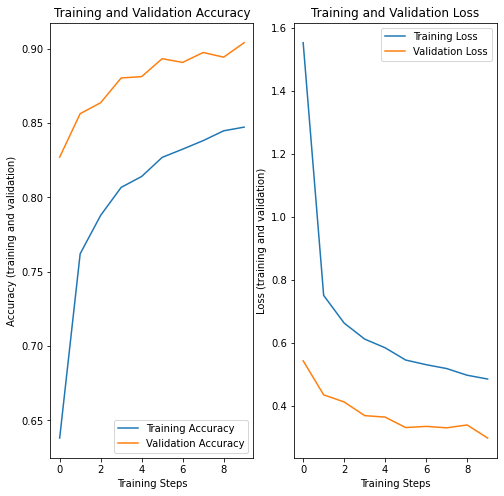

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=10

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

# **Using InceptionV3 while fine tuning the top 2 blocks**

In [14]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in inception.layers[:249]:
    layer.trainable = False
for layer in inception.layers[249:]:
    layer.trainable = True

In [15]:
print("Building model with InceptionV3 with imagenet weights")
model_finetuned = Sequential([
    inception,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.2),
    Dense(38, activation='softmax')
])

# tell the model what cost and optimization method to use
model_finetuned.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


model.summary()

Building model with InceptionV3 with imagenet weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                19494     
Total params: 48,037,190
Trainable params: 37,349,286
Non-trainable params: 10,687,904
_________________________________________________________________


In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

filepath = "model_finetuned_{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="acc", mode="max", patience=15)

callbacks_list = [checkpoint1, early] #early

history = model_finetuned.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set), 
    callbacks=callbacks_list
)

with open('trainHistoryDict.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

Epoch 1/10
1406/1406 [==============================] - 921s 652ms/step - loss: 0.4405 - accuracy: 0.8838 - val_loss: 0.1611 - val_accuracy: 0.9499

Epoch 00001: val_accuracy improved from -inf to 0.94986, saving model to model_finetuned_01-0.95.h5
Epoch 2/10
1406/1406 [==============================] - 922s 656ms/step - loss: 0.1459 - accuracy: 0.9552 - val_loss: 0.1506 - val_accuracy: 0.9553

Epoch 00002: val_accuracy improved from 0.94986 to 0.95527, saving model to model_finetuned_02-0.96.h5
Epoch 3/10
1406/1406 [==============================] - 919s 654ms/step - loss: 0.1139 - accuracy: 0.9652 - val_loss: 0.0848 - val_accuracy: 0.9719

Epoch 00003: val_accuracy improved from 0.95527 to 0.97189, saving model to model_finetuned_03-0.97.h5
Epoch 4/10
1406/1406 [==============================] - 914s 650ms/step - loss: 0.0955 - accuracy: 0.9706 - val_loss: 0.2129 - val_accuracy: 0.9594

Epoch 00004: val_accuracy did not improve from 0.97189
Epoch 5/10
1406/1406 [=====================

Text(0.5, 0, 'Training Steps')

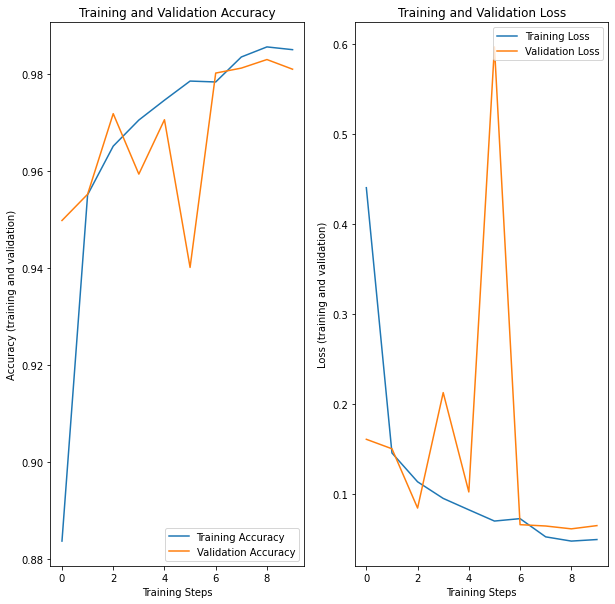

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=10

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")

In [18]:
best_model_finetuned = load_model('./model_finetuned_09-0.98.h5')

In [19]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob

test_dir='../input/new-plant-diseases-dataset/test'

def load_image(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img

classes=['Apple_scab', 'Apple_Black_rot', 'Cedar_apple_rust', 
         'Apple_healthy', 'Blueberry_healthy', 
         'Cherry_Powdery_mildew', 'Cherry_healthy', 
         'Corn_Cercospora_leaf_spot', 'Corn_Common_rust_', 
         'Corn_Northern_Leaf_Blight', 'Corn_healthy', 
         'Grape_Black_rot', 'Grape_Black_Measles', 
         'Grape_Leaf_blight', 'Grape_healthy', 
         'Orange_Haunglongbing', 'Peach_Bacterial_spot', 
         'Peach_healthy', 'Pepper,_bell_Bacterial_spot', 'Pepper,_bell_healthy', 
         'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 
         'Raspberry_healthy', 'Soybean_healthy', 'Squash_Powdery_mildew', 
         'Strawberry_Leaf_scorch', 'Strawberry_healthy', 'Tomato_Bacterial_spot', 
         'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 
         'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites Two-spotted_spider_mite', 
         'Tomato_Target_Spot', 'Tomato_Tomato_Yellow_Leaf_Curl_Virus', 
         'Tomato_Tomato_mosaic_virus', 'Tomato_healthy']

def predict(image):
    probabilities = best_model_finetuned.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [20]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20,20),text_size=15, norm=False, savefig=True): 
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with
    
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
    
    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
            
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
            
    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [21]:
num_of_test_samples=17572

In [22]:
Y_pred = best_model_finetuned.predict(test_set, num_of_test_samples // 50 + 1)
y_pred = np.argmax(Y_pred, axis=1)

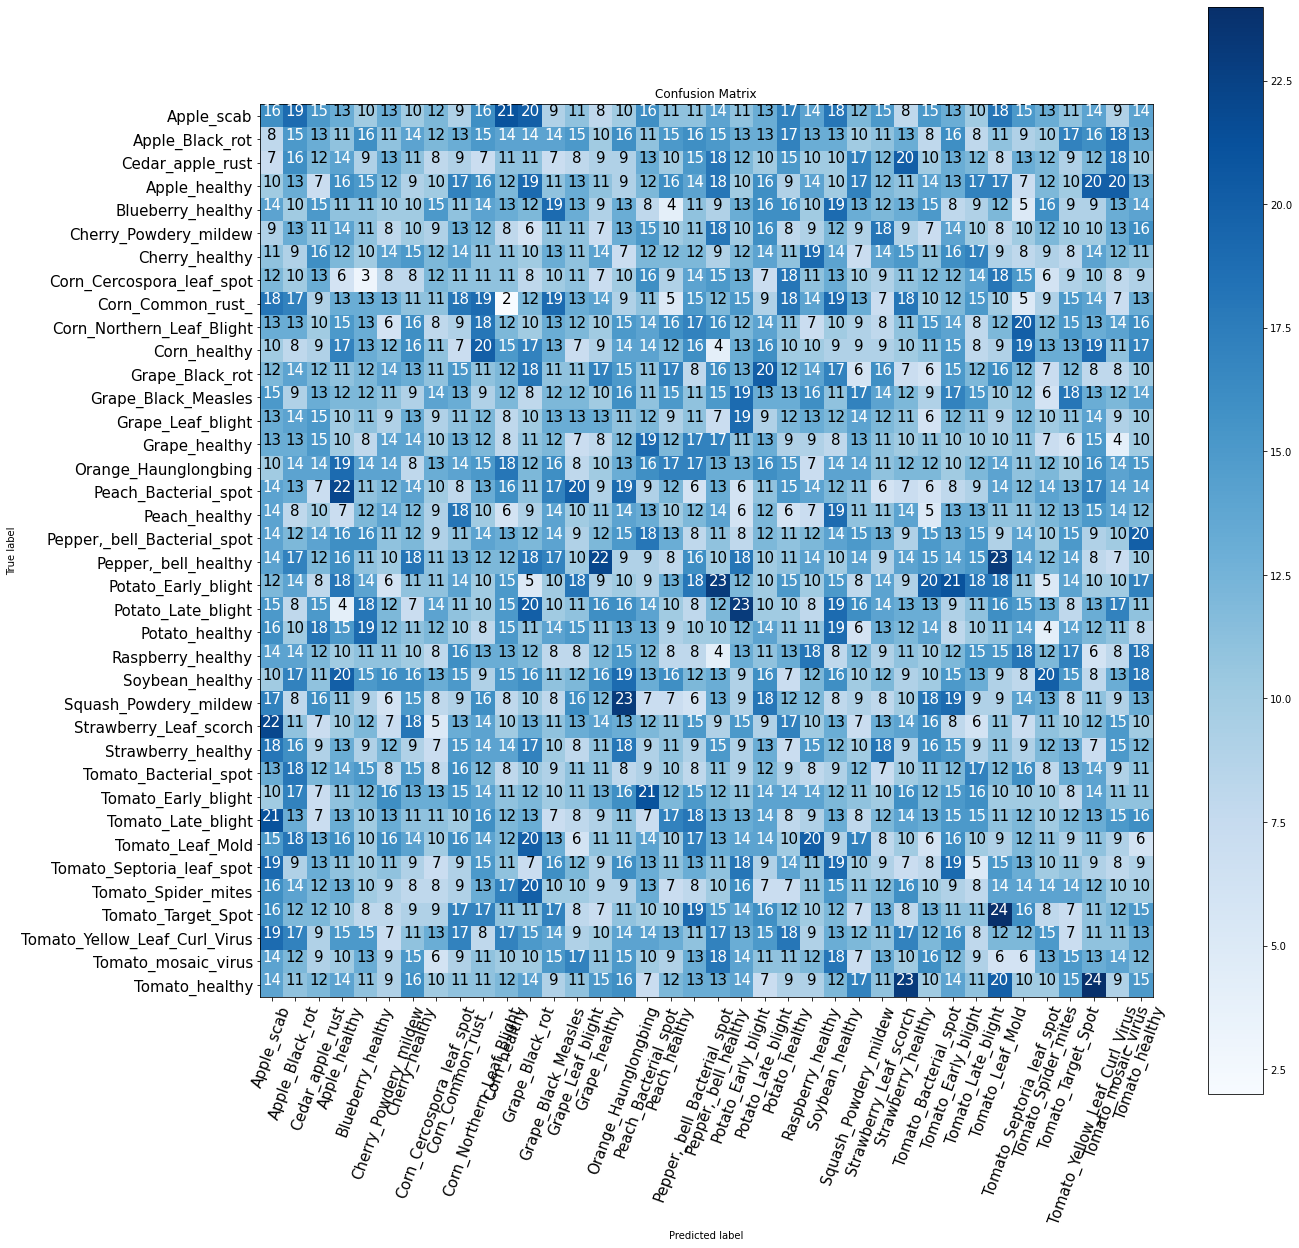

In [23]:
import os
classes=['Apple_scab', 'Apple_Black_rot', 'Cedar_apple_rust', 
         'Apple_healthy', 'Blueberry_healthy', 
         'Cherry_Powdery_mildew', 'Cherry_healthy', 
         'Corn_Cercospora_leaf_spot', 'Corn_Common_rust_', 
         'Corn_Northern_Leaf_Blight', 'Corn_healthy', 
         'Grape_Black_rot', 'Grape_Black_Measles', 
         'Grape_Leaf_blight', 'Grape_healthy', 
         'Orange_Haunglongbing', 'Peach_Bacterial_spot', 
         'Peach_healthy', 'Pepper,_bell_Bacterial_spot', 'Pepper,_bell_healthy', 
         'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 
         'Raspberry_healthy', 'Soybean_healthy', 'Squash_Powdery_mildew', 
         'Strawberry_Leaf_scorch', 'Strawberry_healthy', 'Tomato_Bacterial_spot', 
         'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 
         'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites', 
         'Tomato_Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 
         'Tomato_mosaic_virus', 'Tomato_healthy']
make_confusion_matrix(test_set.classes, y_pred,classes=classes)

ACTUAL CLASS: TomatoEarlyBlight6.JPG, PREDICTED: class: Tomato_Leaf_Mold, confidence: 0.889460


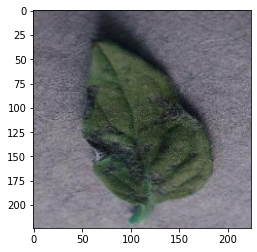

ACTUAL CLASS: TomatoYellowCurlVirus4.JPG, PREDICTED: class: Pepper,_bell_healthy, confidence: 0.726568


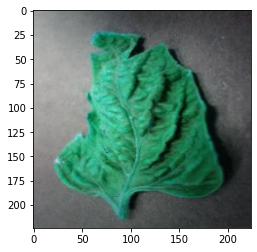

ACTUAL CLASS: TomatoYellowCurlVirus6.JPG, PREDICTED: class: Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.981968


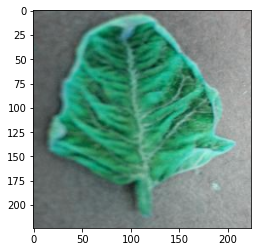

ACTUAL CLASS: PotatoHealthy2.JPG, PREDICTED: class: Potato_healthy, confidence: 1.000000


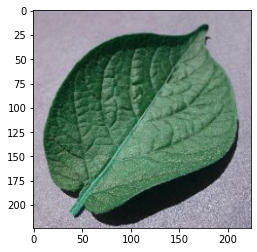

ACTUAL CLASS: TomatoYellowCurlVirus5.JPG, PREDICTED: class: Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.933228


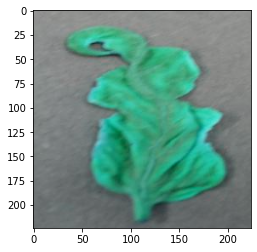

ACTUAL CLASS: PotatoEarlyBlight2.JPG, PREDICTED: class: Potato_Early_blight, confidence: 0.999279


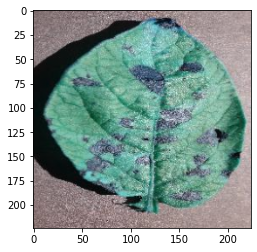

ACTUAL CLASS: TomatoYellowCurlVirus3.JPG, PREDICTED: class: Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.680809


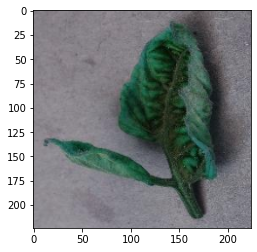

ACTUAL CLASS: TomatoEarlyBlight3.JPG, PREDICTED: class: Tomato_Leaf_Mold, confidence: 0.671331


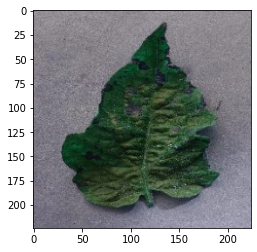

ACTUAL CLASS: CornCommonRust2.JPG, PREDICTED: class: Corn_Common_rust_, confidence: 1.000000


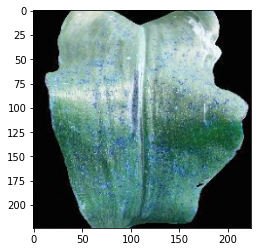

ACTUAL CLASS: AppleScab3.JPG, PREDICTED: class: Apple_scab, confidence: 0.999925


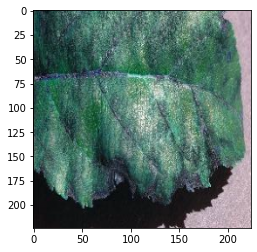

ACTUAL CLASS: TomatoEarlyBlight5.JPG, PREDICTED: class: Tomato_Early_blight, confidence: 0.998083


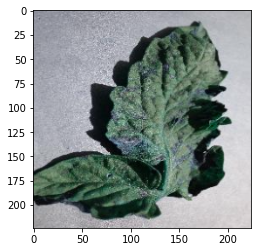

ACTUAL CLASS: TomatoHealthy2.JPG, PREDICTED: class: Apple_healthy, confidence: 0.852042


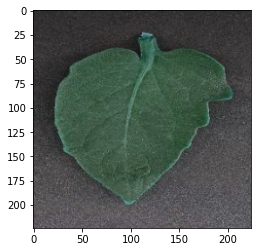

ACTUAL CLASS: CornCommonRust1.JPG, PREDICTED: class: Corn_Common_rust_, confidence: 1.000000


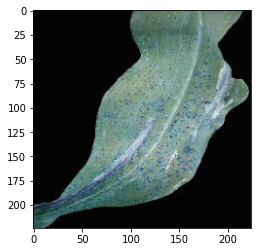

ACTUAL CLASS: PotatoEarlyBlight4.JPG, PREDICTED: class: Potato_Late_blight, confidence: 0.959456


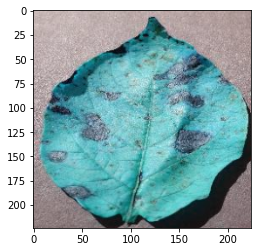

ACTUAL CLASS: TomatoEarlyBlight2.JPG, PREDICTED: class: Tomato_Early_blight, confidence: 0.999859


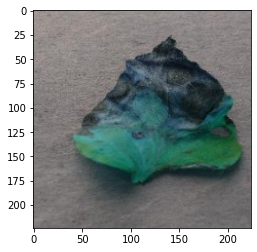

ACTUAL CLASS: TomatoYellowCurlVirus2.JPG, PREDICTED: class: Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.997357


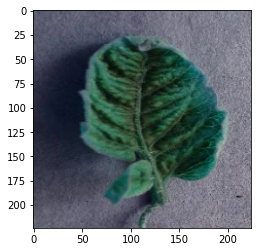

ACTUAL CLASS: CornCommonRust3.JPG, PREDICTED: class: Corn_Common_rust_, confidence: 1.000000


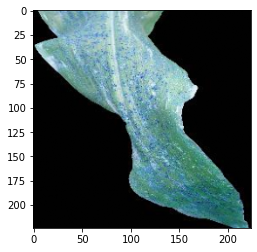

ACTUAL CLASS: TomatoEarlyBlight4.JPG, PREDICTED: class: Tomato_Leaf_Mold, confidence: 0.963022


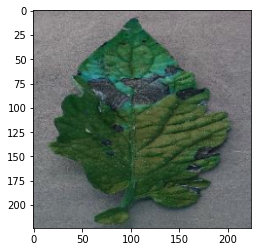

ACTUAL CLASS: AppleCedarRust3.JPG, PREDICTED: class: Cedar_apple_rust, confidence: 0.999342


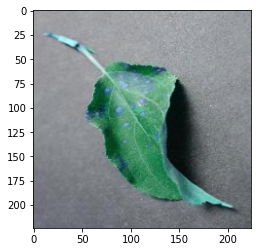

ACTUAL CLASS: TomatoHealthy3.JPG, PREDICTED: class: Tomato_healthy, confidence: 0.964843


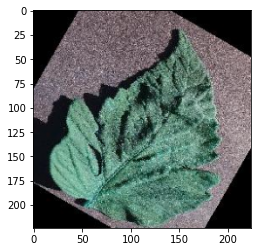

ACTUAL CLASS: AppleScab1.JPG, PREDICTED: class: Apple_scab, confidence: 0.555401


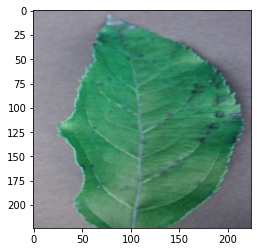

ACTUAL CLASS: TomatoHealthy1.JPG, PREDICTED: class: Tomato_Early_blight, confidence: 0.590912


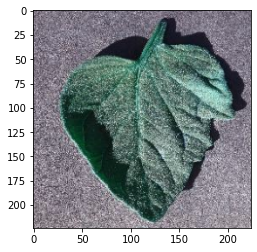

ACTUAL CLASS: AppleScab2.JPG, PREDICTED: class: Apple_scab, confidence: 1.000000


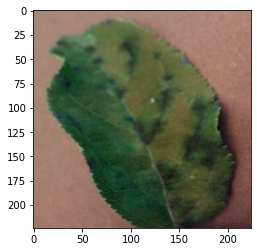

ACTUAL CLASS: AppleCedarRust1.JPG, PREDICTED: class: Cedar_apple_rust, confidence: 1.000000


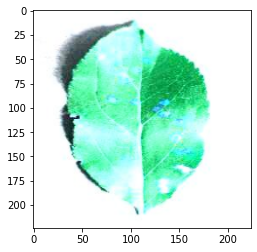

ACTUAL CLASS: PotatoHealthy1.JPG, PREDICTED: class: Potato_healthy, confidence: 0.999995


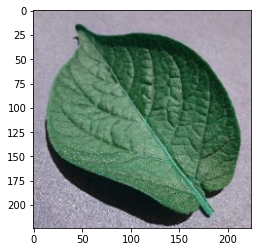

ACTUAL CLASS: TomatoYellowCurlVirus1.JPG, PREDICTED: class: Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.942450


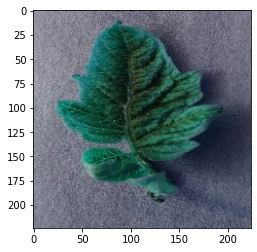

ACTUAL CLASS: PotatoEarlyBlight1.JPG, PREDICTED: class: Potato_Late_blight, confidence: 0.999543


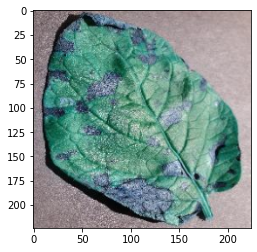

ACTUAL CLASS: AppleCedarRust2.JPG, PREDICTED: class: Cedar_apple_rust, confidence: 1.000000


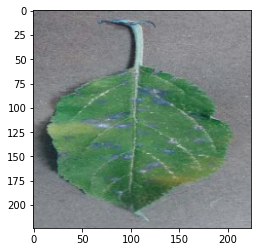

ACTUAL CLASS: PotatoEarlyBlight3.JPG, PREDICTED: class: Potato_Late_blight, confidence: 0.678901


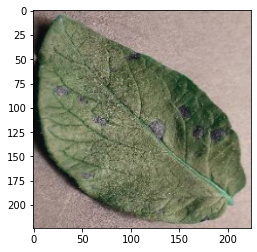

ACTUAL CLASS: TomatoEarlyBlight1.JPG, PREDICTED: class: Tomato_Early_blight, confidence: 0.962891


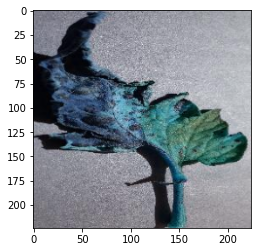

ACTUAL CLASS: AppleCedarRust4.JPG, PREDICTED: class: Cedar_apple_rust, confidence: 1.000000


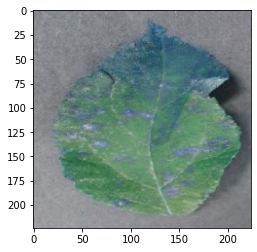

ACTUAL CLASS: PotatoEarlyBlight5.JPG, PREDICTED: class: Potato_Late_blight, confidence: 0.692868


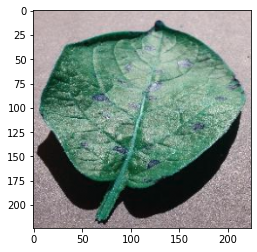

ACTUAL CLASS: TomatoHealthy4.JPG, PREDICTED: class: Tomato_Target_Spot, confidence: 0.999765


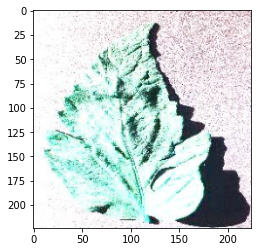

In [25]:
path ='../input/new-plant-diseases-dataset/test/test/'
PList=glob.glob('../input/new-plant-diseases-dataset/test/test/*')
for filename in PList:
    img = load_image(str(filename))
    prediction = predict(img)
    print("ACTUAL CLASS: %s, PREDICTED: class: %s, confidence: %f" % (os.path.basename(filename), list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.show()

# **Using InceptionV3 Whith total finetuning**

In [26]:
# train all existing weights
for layer in inception.layers:
    layer.trainable = True

In [27]:
print("Building model with InceptionV3 with imagenet weights")
model_totalfinetuned = Sequential([
    inception,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.2),
    Dense(38, activation='softmax')
])

# tell the model what cost and optimization method to use
model_totalfinetuned.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


model_totalfinetuned.summary()

Building model with InceptionV3 with imagenet weights
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 38)                19494     
Total params: 48,037,190
Trainable params: 48,002,758
Non-trainable params: 34,432
_________________________________________________________________


In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

filepath = "model_totalfinetuned_{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="acc", mode="max", patience=15)

callbacks_list = [checkpoint1, early] #early

history1 = model_totalfinetuned.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set), 
    callbacks=callbacks_list
)

with open('trainHistory1Dict.txt', 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

Epoch 1/10
1406/1406 [==============================] - 990s 699ms/step - loss: 0.2848 - accuracy: 0.9192 - val_loss: 0.2933 - val_accuracy: 0.9160

Epoch 00001: val_accuracy improved from -inf to 0.91600, saving model to model_totalfinetuned_01-0.92.h5
Epoch 2/10
1406/1406 [==============================] - 995s 708ms/step - loss: 0.1211 - accuracy: 0.9640 - val_loss: 0.3096 - val_accuracy: 0.9184

Epoch 00002: val_accuracy improved from 0.91600 to 0.91845, saving model to model_totalfinetuned_02-0.92.h5
Epoch 3/10
1406/1406 [==============================] - 990s 704ms/step - loss: 0.1104 - accuracy: 0.9665 - val_loss: 0.4736 - val_accuracy: 0.8864

Epoch 00003: val_accuracy did not improve from 0.91845
Epoch 4/10
1406/1406 [==============================] - 986s 701ms/step - loss: 0.0951 - accuracy: 0.9721 - val_loss: 0.2169 - val_accuracy: 0.9367

Epoch 00004: val_accuracy improved from 0.91845 to 0.93672, saving model to model_totalfinetuned_04-0.94.h5
Epoch 5/10
1406/1406 [======

Text(0.5, 0, 'Training Steps')

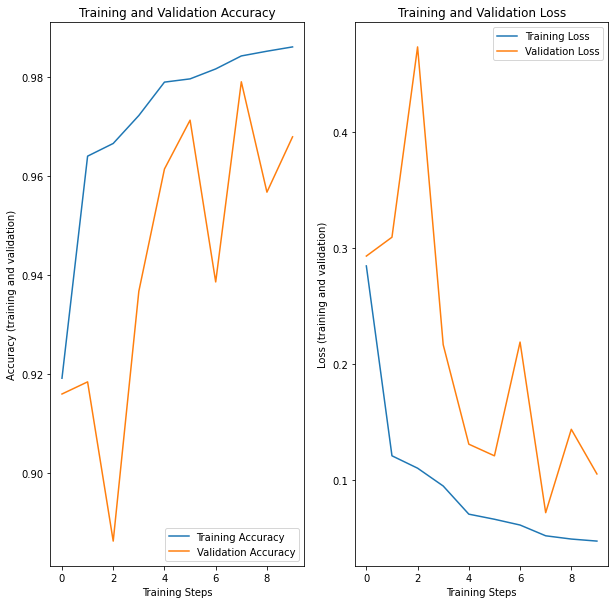

In [29]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']
EPOCHS=10

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")

In [30]:
best_model_totalfinetuned = load_model("/kaggle/working/model_totalfinetuned_08-0.98.h5")

# Conslusion
model InceptionV3 without finetuning-->90%

model InceptionV3 2 top Blocks finetuning-->98%

model InceptionV3 totally finetuned-->96%